## Import dependent libraries

In [1]:
import time
import os
import sys
import math
import random
from numpy import concatenate, array, asarray

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

import tensorflow as tf

import keras
import keras.backend as K

from keras import optimizers
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau, LambdaCallback
from keras.utils import plot_model
from sklearn.externals import joblib

from keras.utils.vis_utils import model_to_dot

from NN.ConvolutionalRNN import ConvolutionalRNN
from NN.jan_17_Model import SimpleModel
from Audio.MidiPlayer import MidiPlayer


Using TensorFlow backend.


## Parameters

In [2]:
# specify the number of lag hours
n_hours = 32
n_features = 2
n_train_hours = None
n_divisions = 4
batch_size = n_hours
epochs = 150
player = MidiPlayer()

## Load dataset

In [3]:
dataset = read_csv('music_data.csv', header=0)
values = dataset.values
values = values.astype('float32')

## Specify columns to plot

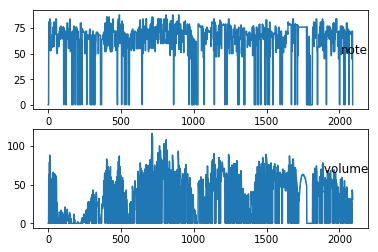

In [4]:
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1


pyplot.show()

## Convert series to supervised learning

In [5]:
dataset = read_csv('music_data.csv', header=1)
n_train_hours = int(len(dataset) * 0.75)
values = dataset.values
values = values.astype('float32')

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    start = time.time()
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    end = time.time()
    print(end - start)
    return agg

## Scale Data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
print(scaled[20:21])


[[ 0.64772731  0.49137932]]


In [8]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

0.022437095642089844


In [9]:
values = reframed.values
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features

In [10]:
train_X = train[:, :n_obs]
# print(train_X)

train_y_notes = train[:, -n_features]
print(train_y_notes[0:1])
train_y_volume = train[:, -n_features -1]

test_X = test[:, :n_obs]
# print(test_X)
test_y_notes = test[:, -n_features]
test_y_volume = test[:, -n_features -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# print(train_X[0:10])

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y_notes.shape, test_X.shape, test_y_notes.shape)
print(test_X[0:1].shape)


[ 0.86363637]
(1568, 32, 2) (1568,) (491, 32, 2) (491,)
(1, 32, 2)


In [11]:
visible = Input(name='input', shape=(n_hours, n_features))
conv_rnn = ConvolutionalRNN(visible, n_hours, n_features, n_divisions)
simple = SimpleModel(visible, 128)

In [12]:
model = conv_rnn.model()
# model = simple.model()

output_notes = Dense(1, activation='sigmoid', name='output_notes')(model)
output_volume = Dense(1, activation='sigmoid', name='output_volume')(model)
# output_length = Dense(1, activation='sigmoid', name='output_length')(hidden_Z)

model = Model(inputs=[visible], outputs=[
                                         output_notes, 
                                         output_volume, 
#                                          output_length
                                        ])

Tensor("input:0", shape=(?, 32, 2), dtype=float32)
num 0
0 8
Tensor("lstm_2/transpose_1:0", shape=(?, ?, 2), dtype=float32)
num 1
8 16
Tensor("lstm_4/transpose_1:0", shape=(?, ?, 2), dtype=float32)
num 2
16 24
Tensor("lstm_6/transpose_1:0", shape=(?, ?, 2), dtype=float32)
num 3
24 32
Tensor("lstm_8/transpose_1:0", shape=(?, ?, 2), dtype=float32)


In [13]:
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer=optimizer)
# model.summary()

In [14]:
# plot_model(model, to_file='model.png')

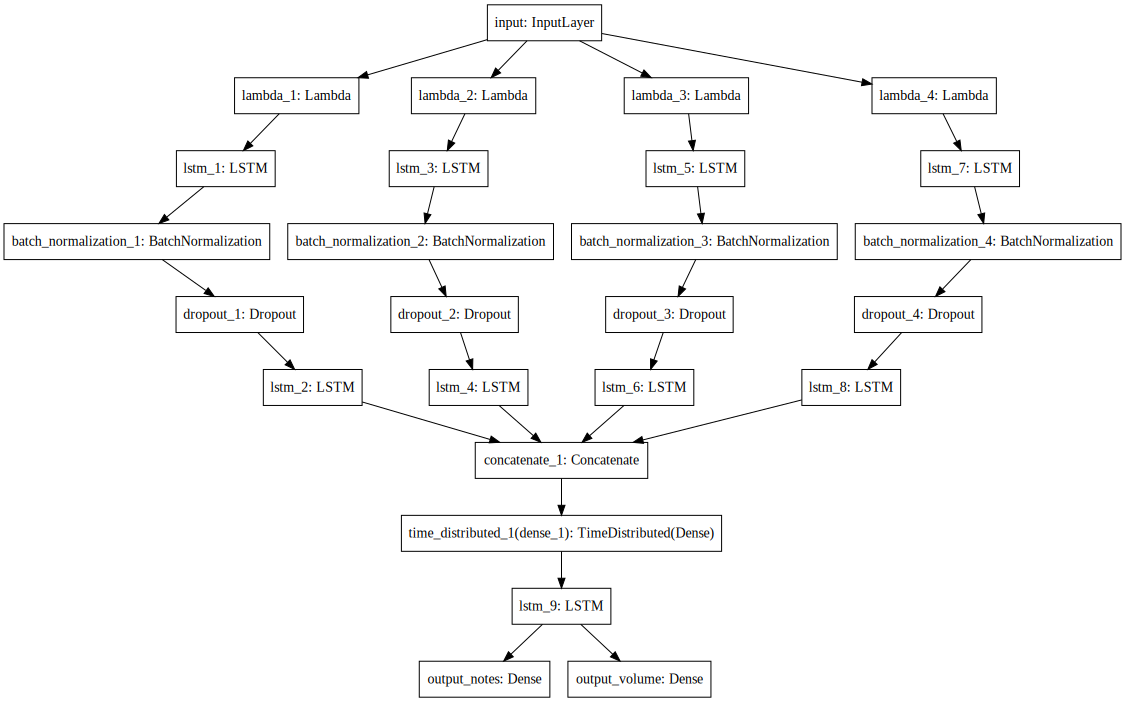

In [15]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
test_cache = dataset.values[30:n_hours + 30].tolist()
test_data = test_cache.copy()
array_to_play = test_cache.copy()

In [17]:
print(test_data)

[[57, 45], [57, 45], [76, 55], [76, 66], [57, 48], [57, 0], [57, 51], [81, 57], [57, 40], [57, 0], [57, 40], [80, 53], [80, 0], [80, 64], [80, 48], [69, 47], [69, 0], [81, 58], [80, 43], [80, 21], [80, 21], [84, 40], [84, 61], [84, 61], [84, 60], [83, 55], [53, 38], [53, 0], [69, 27], [53, 2], [50, 13], [50, 0]]


In [18]:
def process_data(testx):
    testx = DataFrame(data = testx)
    testx = testx.values
    testx = testx.astype('float32')
    testx = scaler.transform(testx)
    return(testx)

In [ ]:
def on_epoch_end(epoch, logs):
    global test_cache
    global test_data
    global array_to_play
#     if epoch % 5 == 0:
    start = time.time()
    print('----- Generating sound after: %d' % epoch)
    for i in range(650):
        if i == 0:
            to_add = [100, 80]
            array_to_play.append(to_add)
        if i == 100 or i == 500:  
            rand = random.randint(10, 15)
            for i in range(rand):
                to_add = [0, 0]
                array_to_play.append(to_add)
                test_data.append(to_add)
            for i in range(rand):
                test_data.pop(0)
                
        if i == 300:    
            for i in range(15):
                rand = random.randint(45, 65)
                to_add = [rand, 45]
                array_to_play.append(to_add)
                test_data.append(to_add)
            for i in range(15):
                test_data.pop(0)
        
        data = process_data(test_data)
        data = data.reshape(1,n_hours,2)
        prediction = model.predict(data)
        prediction = asarray(prediction).ravel().reshape(-1,n_features)
        prediction = scaler.inverse_transform(prediction)
        prediction = prediction.astype('int')
        prediction = prediction[0].tolist()
        test_data.append(prediction)
        test_data.pop(0)
        array_to_play.append(prediction)
    end = time.time()
    print('time:', end - start)
    print('len array_to_play', len(array_to_play))
    for value in array_to_play:
        player.play(value[0], .03, value[1])
    test_data = test_cache.copy()
    array_to_play = test_cache.copy()

    
play_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
history = model.fit(
            {'input': train_X},
            {
                'output_notes': train_y_notes, 
                'output_volume': train_y_volume, 
            },
            validation_data=({'input': test_X},
                             {
                                 'output_notes': test_y_notes, 
                                 'output_volume': test_y_volume, 
                             }), 
            verbose=1,
            shuffle=False,
            epochs=epochs, 
            batch_size=int(batch_size),
            callbacks=[play_callback]
)

Train on 1568 samples, validate on 491 samples
Epoch 1/150
1536/1568 [============================>.] - ETA: 0s - loss: 0.5286 - output_notes_loss: 0.2870 - output_volume_loss: 0.2415----- Generating sound after: 0
time: 8.889573812484741
len array_to_play 726
1568/1568 [==============================] - 42s - loss: 0.5254 - output_notes_loss: 0.2864 - output_volume_loss: 0.2389 - val_loss: 0.4809 - val_output_notes_loss: 0.3055 - val_output_volume_loss: 0.1754
Epoch 2/150
1536/1568 [============================>.] - ETA: 0s - loss: 0.5002 - output_notes_loss: 0.2616 - output_volume_loss: 0.2386----- Generating sound after: 1
time: 8.502833366394043
len array_to_play 724
1568/1568 [==============================] - 40s - loss: 0.4967 - output_notes_loss: 0.2606 - output_volume_loss: 0.2361 - val_loss: 0.4568 - val_output_notes_loss: 0.2837 - val_output_volume_loss: 0.1732
Epoch 3/150
1536/1568 [============================>.] - ETA: 0s - loss: 0.4521 - output_notes_loss: 0.2169 - outpu

time: 8.402139902114868
len array_to_play 726
1568/1568 [==============================] - 42s - loss: 0.3405 - output_notes_loss: 0.1268 - output_volume_loss: 0.2136 - val_loss: 0.3034 - val_output_notes_loss: 0.1514 - val_output_volume_loss: 0.1520
Epoch 21/150
1536/1568 [============================>.] - ETA: 0s - loss: 0.3414 - output_notes_loss: 0.1275 - output_volume_loss: 0.2139----- Generating sound after: 20
time: 8.232399940490723
len array_to_play 723
1568/1568 [==============================] - 41s - loss: 0.3387 - output_notes_loss: 0.1262 - output_volume_loss: 0.2124 - val_loss: 0.3019 - val_output_notes_loss: 0.1512 - val_output_volume_loss: 0.1507
Epoch 22/150
1536/1568 [============================>.] - ETA: 0s - loss: 0.3395 - output_notes_loss: 0.1278 - output_volume_loss: 0.2117----- Generating sound after: 21
time: 8.377994060516357
len array_to_play 728
1568/1568 [==============================] - 41s - loss: 0.3367 - output_notes_loss: 0.1265 - output_volume_loss

1568/1568 [==============================] - 41s - loss: 0.2808 - output_notes_loss: 0.1275 - output_volume_loss: 0.1533 - val_loss: 0.2981 - val_output_notes_loss: 0.1586 - val_output_volume_loss: 0.1395
Epoch 40/150
1536/1568 [============================>.] - ETA: 0s - loss: 0.2803 - output_notes_loss: 0.1289 - output_volume_loss: 0.1514----- Generating sound after: 39
time: 8.30779480934143
len array_to_play 719
1568/1568 [==============================] - 41s - loss: 0.2782 - output_notes_loss: 0.1274 - output_volume_loss: 0.1508 - val_loss: 0.3035 - val_output_notes_loss: 0.1580 - val_output_volume_loss: 0.1455
Epoch 41/150
1536/1568 [============================>.] - ETA: 0s - loss: 0.2768 - output_notes_loss: 0.1294 - output_volume_loss: 0.1475----- Generating sound after: 40
time: 8.38964581489563
len array_to_play 721
1568/1568 [==============================] - 41s - loss: 0.2751 - output_notes_loss: 0.1281 - output_volume_loss: 0.1471 - val_loss: 0.3025 - val_output_notes_l

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
joblib.dump(scaler, 'scaler.pkl')
print('Saved scaler to disk.')

In [ ]:
test_data = test_cache.copy()
array_to_play = test_cache.copy()

In [ ]:
for i in range(500):
    if i == 0:
        to_add = [100, 80]
        array_to_play.append(to_add)
    if i == 100:    
        for i in range(15):
            to_add = [0, 0]
            array_to_play.append(to_add)
            test_data.append(to_add)
        for i in range(15):
            test_data.pop(0)

    if i == 300:    
        for i in range(15):
            rand = random.randint(40, 65)
            to_add = [rand, 45]
            array_to_play.append(to_add)
            test_data.append(to_add)
        for i in range(15):
            test_data.pop(0)

    data = process_data(test_data)
    data = data.reshape(1,n_hours,2)
    prediction = model.predict(data)
    prediction = asarray(prediction).ravel().reshape(-1,n_features)
    prediction = scaler.inverse_transform(prediction)
    prediction = prediction.astype('int')
    prediction = prediction[0].tolist()
    test_data.append(prediction)
    test_data.pop(0)
    array_to_play.append(prediction)
end = time.time()
print('time:', end - start)
print('len array_to_play', len(array_to_play))
for value in array_to_play:
    player.play(value[0], .03, value[1])